In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

# pakai scalecast untuk mempermudah plot series dan eksploratory time series
# pip install scalecast==0.5.2

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# tensorflow untuk LSTM
import tensorflow as tf

2022-07-24 23:12:27.743512: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-24 23:12:27.743552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_excel("./traffic_dan_covid_negara.xlsx")
df_country = df["traffic-chile"]
df_country.index = df["Date"]



<AxesSubplot:xlabel='Date', ylabel='traffic-chile'>

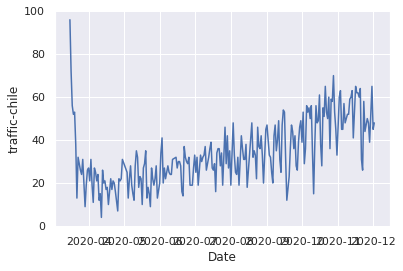

In [3]:
sns.set(rc={'figure.figsize': (15, 8)})
sns.lineplot(x=df_country.index, y=df_country)

<AxesSubplot:xlabel='Date', ylabel='traffic-chile'>

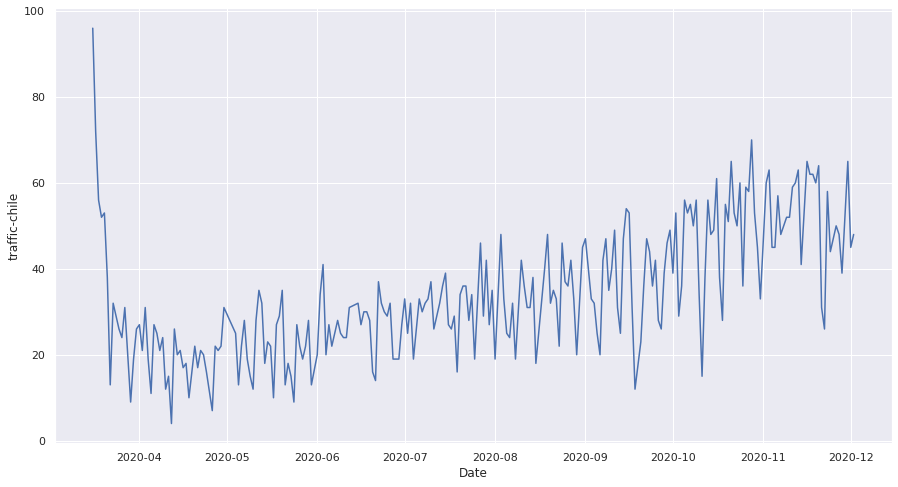

In [4]:
sns.set(rc={'figure.figsize': (15, 8)})
sns.lineplot(x=df_country.index, y=df_country)

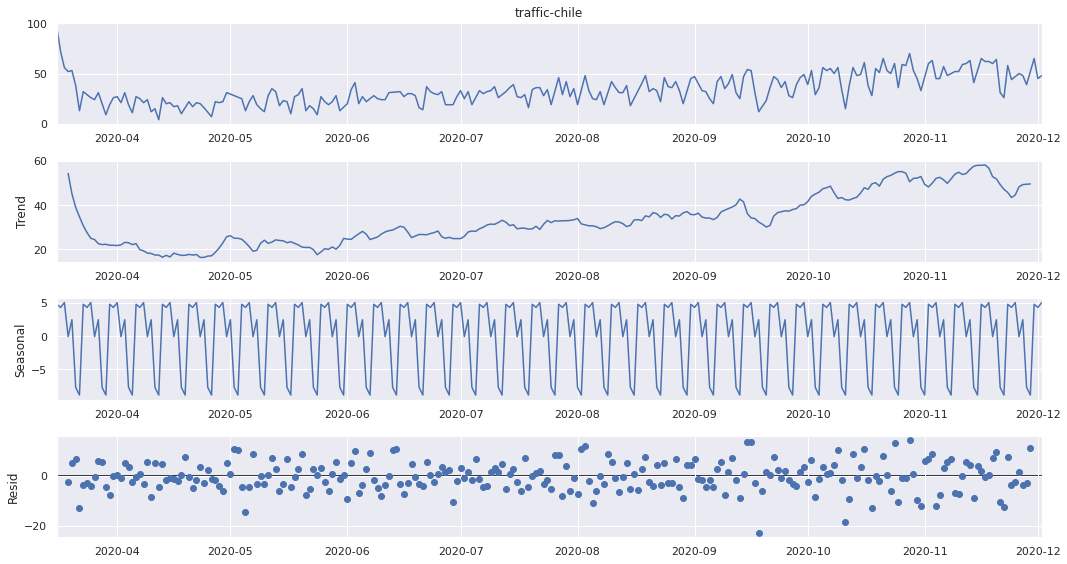

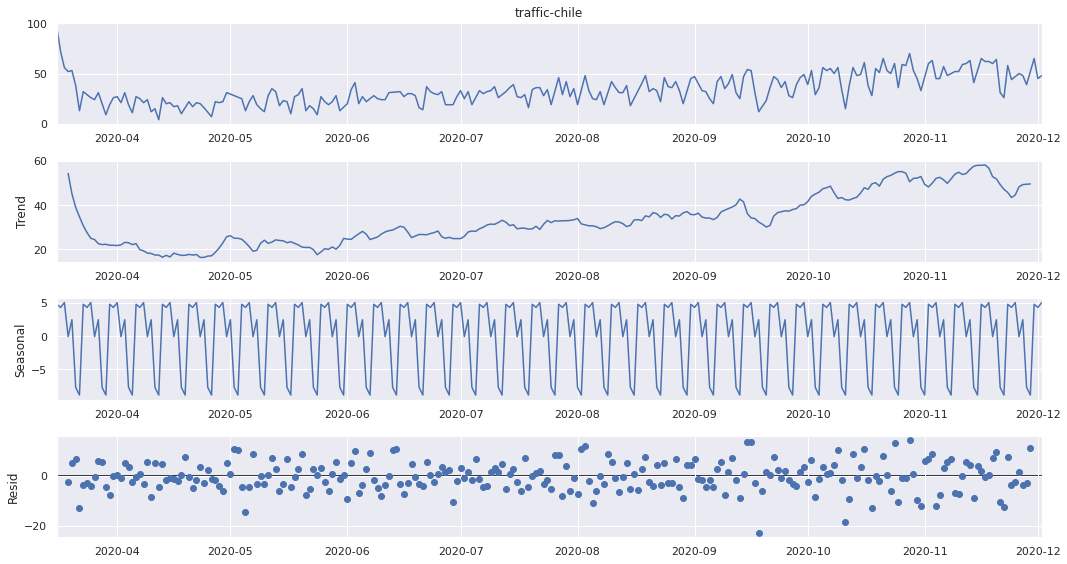

In [5]:
temp = seasonal_decompose(df_country.asfreq(freq='d'))
temp.plot()

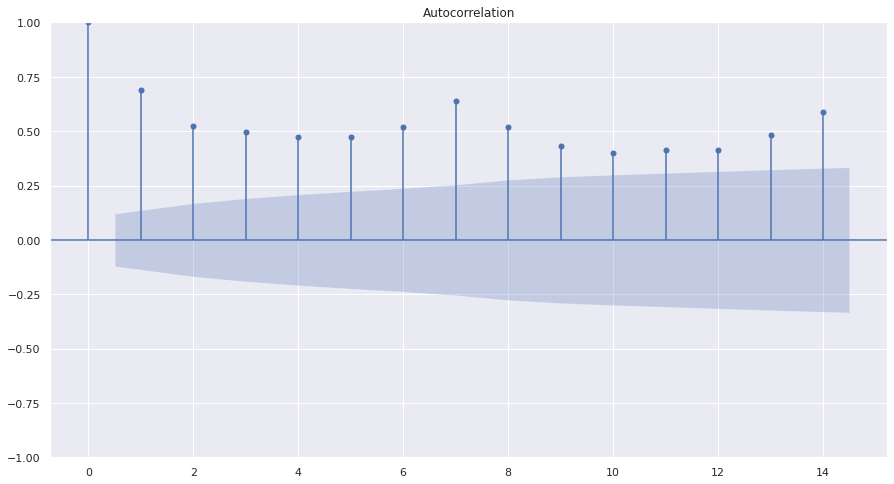

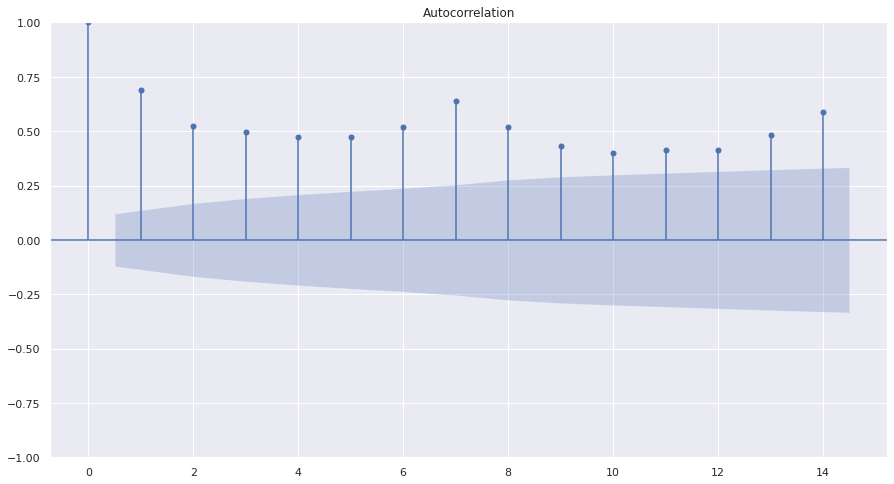

In [6]:
window_size = 14
plot_acf(df_country.asfreq(freq='d'), lags=window_size)

In [7]:
# Tidak ada trend, namun memiliki seasonal

In [8]:
df_country = df_country.to_numpy().reshape(-1,1)

In [9]:
# Memisahkan Train, Validasi, Test

# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
df_scaled = sc.fit_transform(df_country)


In [10]:
xdata = []
ydata = []

for i in range(window_size, len(df_scaled)):
    xdata.append(df_scaled[i-window_size:i])
    ydata.append(df_scaled[i])

xdata, ydata = np.array(xdata), np.array(ydata)

In [11]:
xdata = np.reshape(xdata, (xdata.shape[0], xdata.shape[1], 1))

In [12]:
xtrain, xval, xtest = xdata[0:-(window_size*10)
                            ], xdata[-(window_size*10):-(window_size*5)], xdata[-(window_size*5):]

ytrain, yval, ytest = ydata[0:-(window_size*10)
                            ], ydata[-(window_size*10):-(window_size*5)], ydata[-(window_size*5):]


In [13]:
xdata.shape

(248, 14, 1)

In [14]:
ydata.shape

(248, 1)

In [15]:
batch_size = 8

In [16]:
tf.keras.backend.clear_session()

model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[window_size]),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(200, return_sequences=True)),
    # tf.keras.layers.Bidirectional(
    #     tf.keras.layers.LSTM(200, return_sequences=True)),
    # tf.keras.layers.Bidirectional(
    #     tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(200)),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_tune.summary()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model_tune.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=100, batch_size=batch_size, validation_batch_size=batch_size, callbacks=[lr_schedule])


2022-07-24 23:12:40.952698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 23:12:40.953120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-24 23:12:40.953205: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-07-24 23:12:40.953283: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-07-24 23:12:40.953359: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 14, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 14, 400)          323200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 14, 400)          961600    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              961600    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                        

(0.0001, 10.0, 0.0, 1.0)

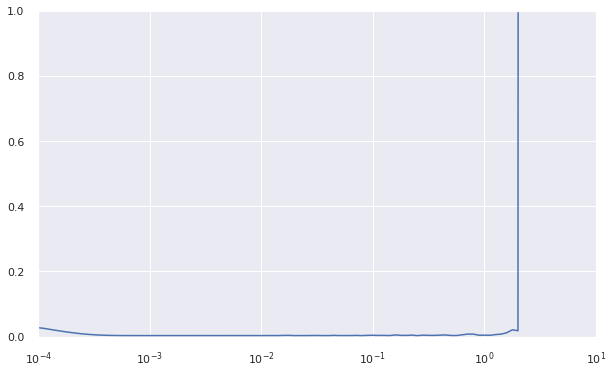

In [17]:
# Define the learning rate array
lrs = 1e-4 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-4, 10, 0, 1])


In [18]:
tf.keras.backend.clear_session()

In [19]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[window_size]),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(200, return_sequences=True)),
    # tf.keras.layers.Bidirectional(
    #     tf.keras.layers.LSTM(200, return_sequences=True)),
    # tf.keras.layers.Bidirectional(
    #     tf.keras.layers.LSTM(200, return_sequences=True)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(200)),
    tf.keras.layers.Dense(1)
])

# Set the learning rate
learning_rate = 1e-1

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=100, batch_size=batch_size, validation_batch_size=batch_size)


Epoch 1/100
14/14 [==============================] - 13s 315ms/step - loss: 0.0089 - mae: 0.1114 - val_loss: 0.0059 - val_mae: 0.0877
Epoch 2/100
14/14 [==============================] - 2s 150ms/step - loss: 0.0042 - mae: 0.0763 - val_loss: 0.0092 - val_mae: 0.1118
Epoch 3/100
14/14 [==============================] - 2s 146ms/step - loss: 0.0037 - mae: 0.0697 - val_loss: 0.0098 - val_mae: 0.1156
Epoch 4/100
14/14 [==============================] - 2s 149ms/step - loss: 0.0034 - mae: 0.0686 - val_loss: 0.0136 - val_mae: 0.1392
Epoch 5/100
14/14 [==============================] - 2s 149ms/step - loss: 0.0041 - mae: 0.0735 - val_loss: 0.0067 - val_mae: 0.0948
Epoch 6/100
14/14 [==============================] - 2s 151ms/step - loss: 0.0039 - mae: 0.0717 - val_loss: 0.0159 - val_mae: 0.1519
Epoch 7/100
14/14 [==============================] - 2s 151ms/step - loss: 0.0038 - mae: 0.0695 - val_loss: 0.0081 - val_mae: 0.1052
Epoch 8/100
14/14 [==============================] - 2s 151ms/step -

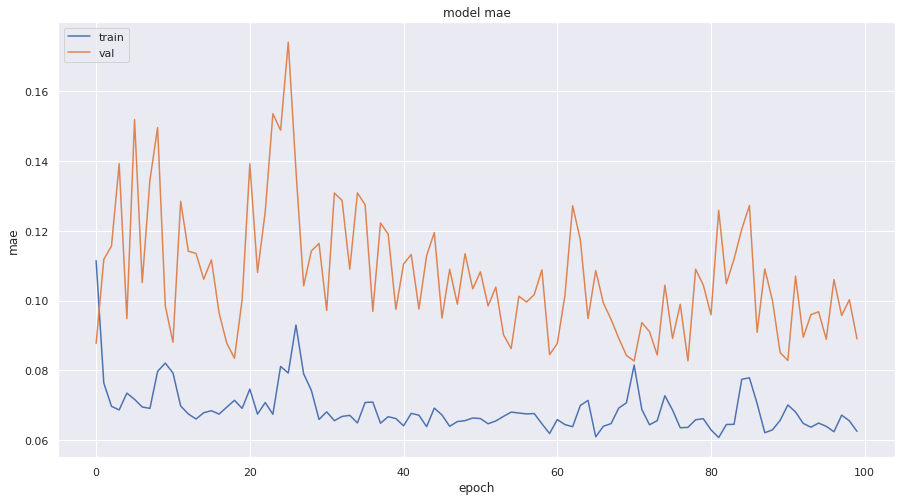

In [20]:
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

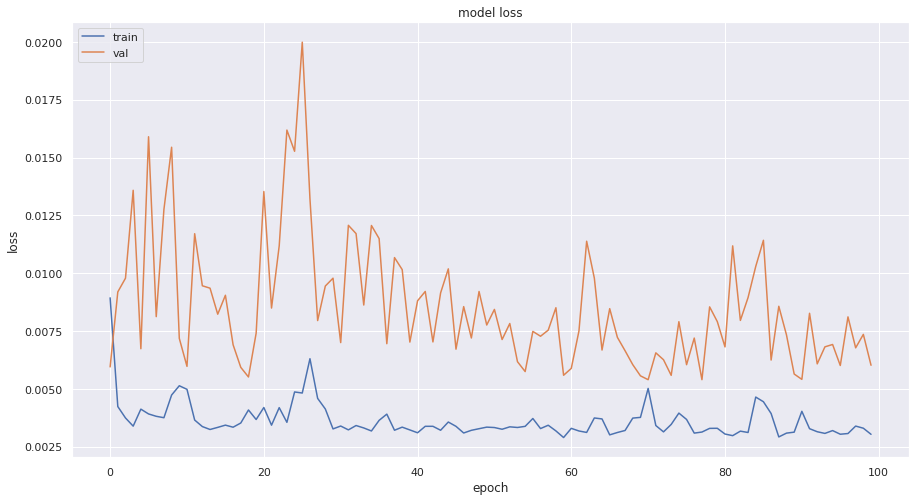

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

8/8 [==============================] - 3s 64ms/step


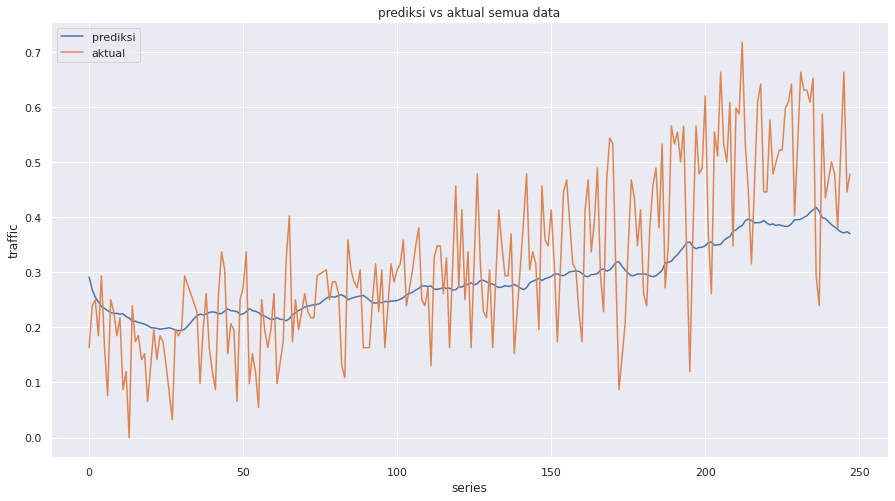

In [22]:
ypred = model.predict(xdata)

plt.plot(ypred)
plt.plot(ydata)
plt.title('prediksi vs aktual semua data')
plt.ylabel('traffic')
plt.xlabel('series')
plt.legend(['prediksi', 'aktual'], loc='upper left')
plt.show()


3/3 [==============================] - 0s 52ms/step


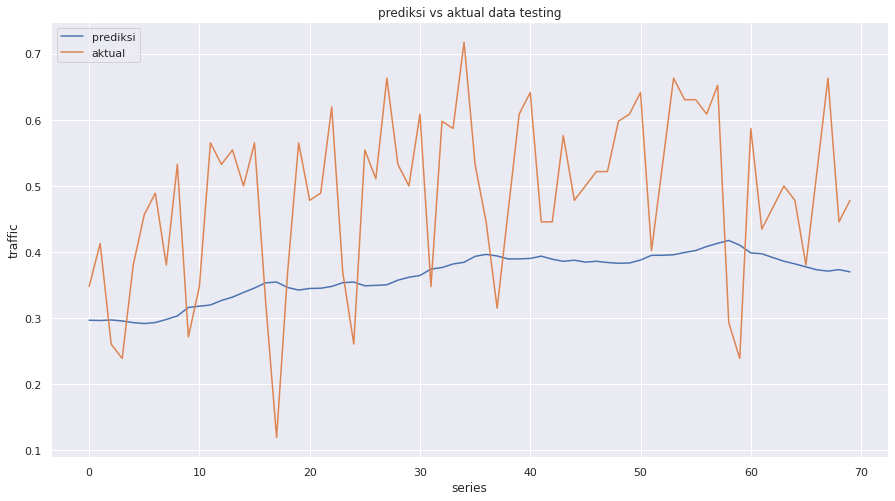

In [23]:
ypred = model.predict(xtest)

plt.plot(ypred)
plt.plot(ytest)
plt.title('prediksi vs aktual data testing')
plt.ylabel('traffic')
plt.xlabel('series')
plt.legend(['prediksi', 'aktual'], loc='upper left')
plt.show()